In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"]= os.getenv("GOOGLE_API_KEY")

os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]= os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]= os.getenv("LANGCHAIN_TRACING_V2")

In [15]:
from langchain_openai import ChatOpenAI
llm_open = ChatOpenAI(model = "gpt-4o-mini")
#result = llm.invoke("What is the difference between RAG and Agentic RAG?")
#print(result.content)

In [35]:
from langchain_groq import ChatGroq
llm_groq = ChatGroq(model = "deepseek-r1-distill-llama-70b")

In [22]:
llm_open.invoke("What is 10 multiplied by 20?")

AIMessage(content='10 multiplied by 20 is 200.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 16, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BxPvzIzcDkLhPNfYK1U5LBgSuz2Sw', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0231c4ab-cb7d-449b-836a-25ea7b43d20a-0', usage_metadata={'input_tokens': 16, 'output_tokens': 9, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

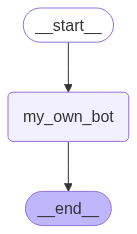

In [4]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

def my_own_bot(state: State):
    return {"messages":[llm_open.invoke(state['messages'])]}

from langgraph.graph import StateGraph, START,END
graph = StateGraph(State)

# node add
graph.add_node("my_own_bot",my_own_bot)

# Edges
graph.add_edge(START,"my_own_bot")
graph.add_edge("my_own_bot",END)

# Compile
graph_builder = graph.compile()


from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [5]:
graph_builder.invoke({'messages':"Hey I am planning to teach Agentic AI"})

{'messages': [HumanMessage(content='Hey I am planning to teach Agentic AI', additional_kwargs={}, response_metadata={}, id='1cefda5e-b206-4979-843b-38dc6cf52dcd'),
  AIMessage(content='That sounds like an exciting and relevant topic! Teaching Agentic AI involves discussing concepts related to autonomy, decision-making, and the capabilities of AI systems to act independently in specific contexts. Here are some suggestions on how to structure your course or teaching material:\n\n### 1. **Introduction to Agentic AI**\n   - **Definition and Overview**\n     - What is Agentic AI? Discuss autonomous systems that can make decisions and perform tasks without human intervention.\n   - **Historical Context**\n     - Overview of AI development leading to Agentic AI (from rule-based systems to machine learning and deep learning).\n\n### 2. **Core Concepts**\n   - **Autonomy and Agency**\n     - Define autonomy in AI and the implications of AI systems having agency.\n   - **Decision-Making Processe

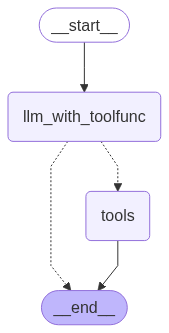

In [36]:
# Define Tools 
def my_add(a:int, b:int)-> int:
    """  Addition of a and b and not multiplication
    Args:
        a(int) : first int
        b(int) : second int
    Return:
        int:
    """
    return a+b

# Bind the tool with LLM - Lets LLM know which tool / function it can use for answering
llm_with_tools = llm_groq.bind_tools([my_add])
# We also have to create a list of tools 
tools = [my_add]



class State(TypedDict):
    messages:Annotated[list,add_messages]

def llm_with_toolfunc(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
builder = StateGraph(State)


builder.add_node("llm_with_toolfunc",llm_with_toolfunc)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,"llm_with_toolfunc")
builder.add_conditional_edges("llm_with_toolfunc",tools_condition) # Inside this tool condition LLM matches user input with the tool docstrings
builder.add_edge("tools",END)

graph_builder = builder.compile()
from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [39]:
from pprint import pprint
messages = graph_builder.invoke({"messages":"What is 30 plus 50 plus 15 ?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 30 plus 50 plus 15 ?
================================== Ai Message ==================================

To calculate \(30 + 50 + 15\), we'll use the `my_add` function twice:

1. First, add 30 and 50:
Tool Calls:
  my_add (k9yx17ywq)
 Call ID: k9yx17ywq
  Args:
    a: 30
    b: 50
================================= Tool Message =================================
Name: my_add

80


In [38]:
from pprint import pprint
messages = graph_builder.invoke({"messages":"What is Agentic AI in 30 words?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Agentic AI in 30 words?
================================== Ai Message ==================================

Agentic AI refers to autonomous systems that act on behalf of users, making decisions and learning to achieve specific goals in dynamic environments, optimizing processes and solving complex problems.


In [34]:
from pprint import pprint
messages = graph_builder.invoke({"messages":"What is 10 multiplied by 20. "})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 10 multiplied by 20. 
================================== Ai Message ==================================

To assist with the multiplication, I need a function that supports multiplication. However, the only available function is `my_add`, which performs addition. Therefore, I cannot directly provide the product of 10 and 20 using the given tools.

If you'd like, I can help you add numbers using `my_add` instead. Let me know how you'd like to proceed!
